# 5. Clustering and EM

In [17]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
set_notebook_preferences()

## 5.1 K-means algorithm

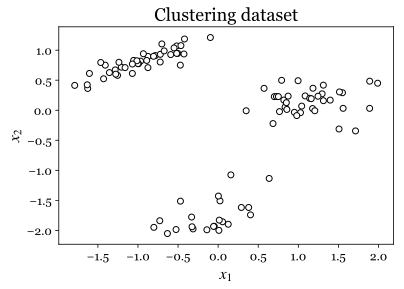

In [18]:
x = np.load('clustering_2d.npy')

plt.scatter(x[:, 0], x[:, 1], marker = 'o', color = 'white', edgecolor = 'black')
beautify_plot({"title":"Clustering dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()

## K-Means

Under the k-means model, each datapoint may belong to one of k classes. Each point's class membership is denoted by the 1-of-K binary indicator variable $s_{nk}$ where $s_{nk} = 1$ means the $n^{th}$ point belongs to the $k^{th}$ class and $s_{nk} = 0$ means the opposite. The k-means algorithm then tries to minimise the cost function

\begin{align}
\mathcal{C} = \sum_{n = 1}^N \sum_{k = 1}^K s_{nk} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2
\end{align}

with respect to $s_{nk}$ and $\mathbf{m}_k$. This is achieved by repeating the two-step process:

1. Minimise $\mathcal{C}$ with respect to $s_{nk}$ keeping $\mathbf{m}_k$ fixed.


2. Minimise $\mathcal{C}$ with respect to $\mathbf{m}_k$ keeping $s_{nk}$ fixed.

This process is repeated until convergence, i.e. when the $s_{nk}$ no longer change. For each $n$, the $s_{nk}$ which minimises $\mathcal{C}$ for given $\mathbf{m}_k$ (remembering that $s_{nk}$ is a 1-of-K binary variable and as such must contain a single $1$ and all other entries set to $0$ for each $n$) is

\begin{align}
s_{nk} = 1 \text{ for } k = \text{arg } \max_{k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2, \text{ and } s_{nk} = 0 \text{ for all other $k$}
\end{align}

The $\mathbf{m}_k$ which minimises $\mathcal{C}$ for fixed $s_{nk}$ can also be found easily by setting the derivative of $\mathcal{C}$ w.r.t. $\mathbf{m}_k$ to $0$:

\begin{align}
\frac{\partial \mathcal{C}}{\partial \mathbf{m}_k} &= \sum_{n = 1}^N s_{nk} (\mathbf{m}_k - \mathbf{x}_n)\\
~\\
&= \sum_{s_{nk} = 1}  (\mathbf{m}_k - \mathbf{x}_n) = 0\\
~\\
\mathbf{m}_k &= \frac{1}{\sum_n s_{nk}}\sum_{s_{nk} = 1}\mathbf{x}_n = \frac{1}{N_k}\sum_{s_{nk} = 1}\mathbf{x}_n\\
\end{align}

where the sum $\sum_{s_{nk} = 1}$ denotes the sum over all datapoints which belong to class $k$. Note also that $N_k = \sum_n s_{nk}$ is the count of points in class $k$. In plain words, k-means assumes each datapoint may belong to one of $K$ available classes, and determines class membership by allocating the points so as to minimise the squared distance of each point from its class's mean. One obvious question at this point is how to choose $K$. You can easily show that increasing $K$ will strictly decrease $\mathcal{C}$. Think of the limit where $K = N$ and each cluster is allocated exaclty one point and is centered at that point $-$ then $\mathcal{C} = 0$. Also, how would you initialise class membership? Does the k-means algorithm converge or is there a chance it might not $-$ for certain datasets? Does the algorithm have a unique (global) maximum or could it converge to a local maximum?

We defer these questions for later, and assume $K = 3$ (judged from the dataset) and a completely random initialisation of class membership.

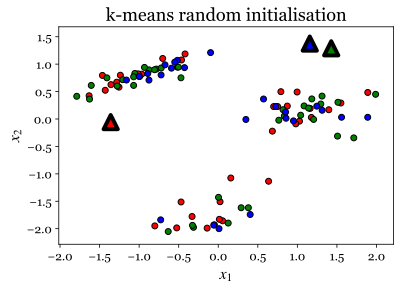

In [19]:
K = 3
N = x.shape[0]

mus = np.random.rand(K, 2)*4 - 2
s = np.zeros(shape = (N, K))
assignments = np.random.choice(np.arange(0, K), N)
s[np.arange(s.shape[0]), assignments] = 1
colors = ['r', 'g', 'b']

for idx, mu in enumerate(mus):
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '4')
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :]
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black')
beautify_plot({"title":"k-means random initialisation", "x":"$x_1$", "y":"$x_2$"})
plt.show()

In [20]:
xs = np.stack([x]*K, axis = 1)
losses = [np.sum(s*np.sum((xs - mus)**2, axis = 2))]
converged = False

while not(converged):
    
    mus = (s.T).dot(x)
    mus /= s.sum(axis = 0).reshape((-1, 1))
    
    distances = np.sum((xs - mus)**2, axis = 2)
    min_idx = np.argmin(distances, axis = 1)
    s_prev = s.copy()
    s = np.zeros_like(s)
    s[np.arange(s.shape[0]), min_idx] = 1
    
    losses.append(np.sum(s*np.sum((xs - mus)**2, axis = 2)))
    converged = np.prod(np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1))

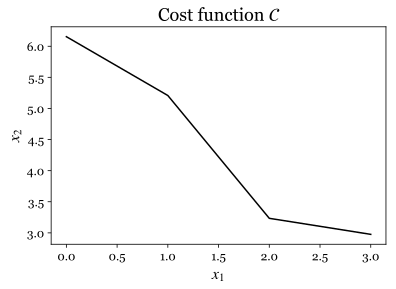

In [21]:
plt.plot(np.arange(len(losses)), np.log(losses), color = 'black')
beautify_plot({"title":"Cost function $\mathcal{C}$", "x":"$x_1$", "y":"$x_2$"})
plt.show()

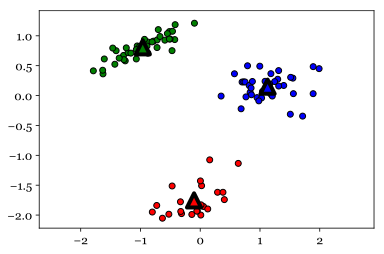

In [22]:
for idx, mu in enumerate(mus):
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '4')
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :]
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black', zorder = 1)
plt.axis('equal')
plt.show()

Clustering can be applied on a variety of different contexts. In the next example we will separately apply k-means on a grayscale and a coloured image. Each image can be thought of as a dataset of pixels: in the grayscale image each pixel is in a $1$-dimensional intensity space whereas in the coloured case, the pixels are in a $3$-dimensional space where each dimension represents the pixel's red, green or blue colour intensity. Let's have a look at the images:

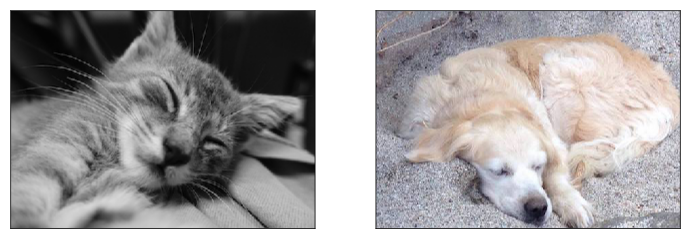

In [23]:
plt.figure(figsize = (12, 12))
plt.subplot(121)
cat = plt.imread('sleepy_cat.jpg')
plt.imshow(cat, origin = 'upper')
remove_axes()

plt.subplot(122)
dog = plt.imread('sleepy_dog.jpg')
plt.imshow(dog, origin = 'upper')
remove_axes()
plt.show()

For convenience, we will also write an implementation of k-means using a custom function, which performs the whole optimisation process:

In [24]:
def k_means(x, K, max_steps, mu_init):
    N, D = x.shape
    mu = mu_init.copy()

    s = np.zeros(shape = (N, K))
    assignments = np.random.choice(np.arange(0, K), N)
    s[np.arange(s.shape[0]), assignments] = 1
    
    x_stacked = np.stack([x]*K, axis = 1)
    losses = [np.sum(s*np.sum((x_stacked - mu)**2, axis = 2))]
    converged = False
    
    for i in range(max_steps):

        mus = (s.T).dot(x)
        s_sum = s.sum(axis = 0).reshape((-1, 1))
        s_sum[np.where(s_sum < 1)] = 1
        mus /= s_sum

        distances = np.sum((x_stacked - mus)**2, axis = 2)
        min_idx = np.argmin(distances, axis = 1)
        s_prev = s.copy()
        s = np.zeros_like(s)
        s[np.arange(s.shape[0]), min_idx] = 1

        losses.append(np.sum(s*np.sum((x_stacked - mus)**2, axis = 2)))
        
        if np.prod(np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1)):
            break
        
    return s, mus, losses

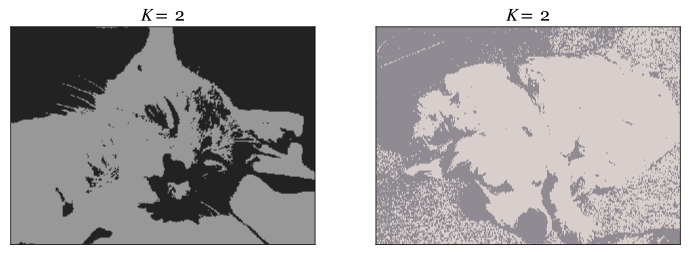

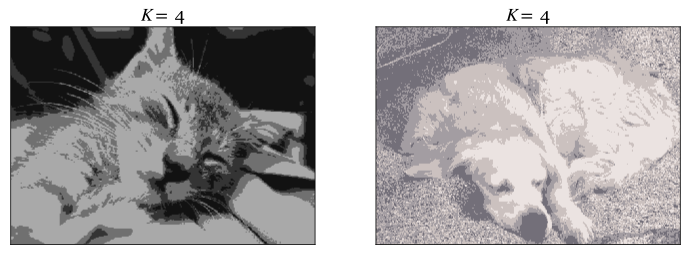

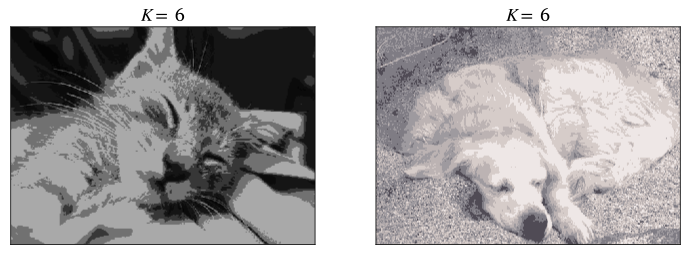

In [25]:
flat_dog, flat_cat = dog.reshape((-1, 3)), cat.reshape((-1, 1))

for K in np.arange(2, 7, 2):
    s_dog, mu_dog, losses_dog = k_means(flat_dog, K, 10, np.random.rand(K, 1)*256)
    s_cat, mu_cat, losses_cat = k_means(flat_cat, K, 10, np.random.rand(K, 1)*256)
    
    dog_colors = [np.mean(flat_dog[np.where(np.argmax(s_dog, axis = -1) == k)], axis = 0) for k in np.arange(K)]
    cat_colors = [np.mean(flat_cat[np.where(np.argmax(s_cat, axis = -1) == k)], axis = 0) for k in np.arange(K)]
    
    K_colored_dog = flat_dog.copy()
    K_colored_cat = flat_cat.copy()
    
    for k in range(K):
        K_colored_dog[np.where(np.argmax(s_dog, axis = -1) == k)[0], :] = dog_colors[k]
        K_colored_cat[np.where(np.argmax(s_cat, axis = -1) == k)[0], :] = cat_colors[k]

    K_colored_dog = K_colored_dog.reshape(dog.shape)
    K_colored_cat = K_colored_cat.reshape(cat.shape)
    
    plt.figure(figsize = (12, 12))
    plt.subplot(121)
    plt.imshow(K_colored_cat, origin = 'upper')
    beautify_plot({"title":"$K =$ {}".format(K)})
    remove_axes()

    plt.subplot(122)
    plt.imshow(K_colored_dog, origin = 'upper')
    beautify_plot({"title":"$K =$ {}".format(K)})
    remove_axes()
    
    plt.show()

## Mixture of gaussians

Likelihood of generative model:

$$p(\mathbf{X}| \mathbf{s}, \theta) = \prod^K_{k = 1}\prod^N_{n = 1} \bigg[\pi_k\text{exp}\big({-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}\boldsymbol{\Sigma}^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\bigg]^{s_{nk}}$$

Lower bound on data log-likelihood:

\begin{align}
\mathcal{F}(q(\mathbf{s}), \theta) &= \text{log}~p(\mathbf{X}|\theta) - \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}\frac{q(\mathbf{s})}{p(\mathbf{s}|\mathbf{X}, \theta)}\\
\end{align}

E-step, maximize $\mathcal{F}$ w.r.t. $q(\mathbf{s})$, equivalent to minimizing the KL divergence:

\begin{align}
KL(q(\mathbf{s}) || p(\mathbf{s}|\mathbf{X}, \theta)) = \sum_{\mathbf{s}} q(\mathbf{s}) \text{log}\frac{p(\mathbf{s}|\mathbf{X}, \theta)}{q(\mathbf{s})}\\
\end{align}

which occurs when:

\begin{align}
q(\mathbf{s}) &= p(\mathbf{s}|\mathbf{X}, \theta) \propto p(\mathbf{X}| \mathbf{s}, \theta) p(\mathbf{s} | \theta)\\
\implies q(s_n = k) &= \frac{\pi_k}{\sqrt{2\pi |\boldsymbol{\Sigma}_k|}} \text{exp}\big({-\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top}\boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)
\end{align}

M-step, maximize $\mathcal{F}$ w.r.t. $\theta = \{\boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k, \pi_k\}$, and because $q(\mathbf{s})$ is independent of $\theta$ this is equivalent to maximizing:

\begin{align}
\sum_{\mathbf{s}} q(\mathbf{s}) \text{log}~p(\mathbf{s}, \mathbf{X}| \theta) = \sum_{n = 1}^N\sum_{k = 1}^K q(s_n = k) \big[\text{log}(\pi_k) - \frac{1}{2} \text{log}|\boldsymbol{\Sigma}_k| -\frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\big] 
\end{align}

\begin{align}
\frac{\partial \mathcal{F}}{\partial \boldsymbol{\mu}_k} &= \sum_{n = 1}^N q(s_n = k) \big[ \boldsymbol{\Sigma}^{-1}_k(\mathbf{x}_n - \boldsymbol{\mu}_k)\big)\big] = 0\\
\implies \boldsymbol{\mu}_k &= \frac{1}{N_k}\sum_{n = 1}^N q(s_n = k) \mathbf{x}_n\\
&\text{where } N_k = \sum_{n = 1}^N q(s_n = k)\\
\implies \pi_k &= \frac{N_k}{N}\\
\implies \boldsymbol{\Sigma}_k &= \frac{1}{N} \sum_{n = 1}^N q(s_n = k) (\mathbf{x}_n - \boldsymbol{\mu}_k)(\mathbf{x}_n - \boldsymbol{\mu}_k)^\top
\end{align}

(3, 100) (100, 2)


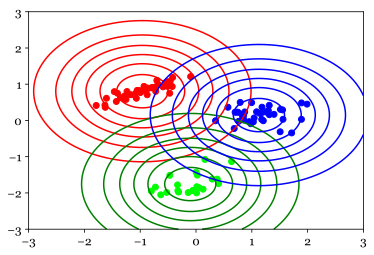

(3, 100) (100, 2)


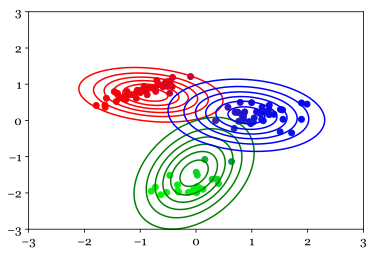

(3, 100) (100, 2)


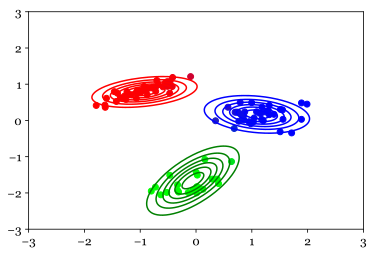

(3, 100) (100, 2)


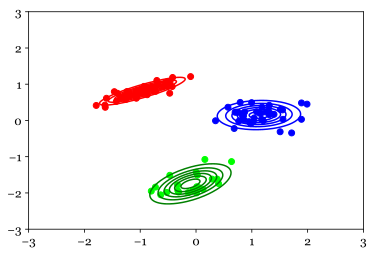

(3, 100) (100, 2)


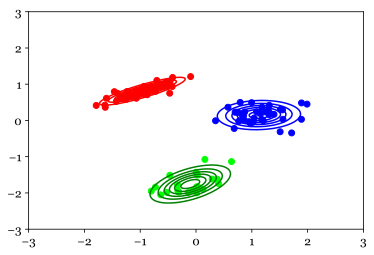

In [30]:
x = np.load('clustering_2d.npy')
K = 3
q, mus, losses = k_means(x, 3, 20, np.random.rand(3, 2))

q = q.T
mu = np.copy(mus)
pi = np.ones(shape = (K,))/K
cov = np.stack([np.eye(2)]*K)*1
xs = np.stack([x]*K, axis = 1)

x_, y_ = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 250))
grid = np.stack([x_, y_], axis = -1)
colors = ['red', 'green', 'blue']

for n in range(5):
    
    plt.clf()
    if n % 1 == 0:
        for k in range(K):

            cov_ = cov[k]
            mu_ = mu[k]

            exp_ = np.exp(-0.5*np.sum((grid - mu_).dot(np.linalg.inv(cov_))*(grid - mu_), axis = -1))
            plt.contour(x_, y_, exp_, colors = colors[k])
        print(q.shape, x.shape)
        plt.scatter(x[:, 0], x[:, 1], c = q.T)

        plt.show()
    
    # E-step
    prec = np.linalg.inv(cov)
    exponent = np.einsum('ijk, nik -> nij', prec, xs - mu)
    exponent = np.einsum('nij, nij -> ni', xs - mu, exponent)
    exp_term = np.exp(-1/2*exponent)
    q = (exp_term*pi/(2*np.pi*np.linalg.det(cov))**0.5).T
    q = q/q.sum(axis = 0)
    
    # M-step
    N_k = np.sum(q, axis = 1)
    mu = (q.dot(x).T/N_k).T
    
    pi = N_k/N
        
    cov = np.einsum('ijk, ijl -> ijkl', xs - mu, xs - mu)
    cov = np.einsum('ij, jikl -> ijkl', q, cov)
    cov = (np.sum(cov, axis = 1).T/N_k).T